In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/GMGD.jl")

Gaussian_2d (generic function with 6 methods)

## Gaussian function

Consider the following inverse problem 

$$
\begin{align*}
y = 
A\theta
+\eta
\qquad 
y = 
\begin{bmatrix}
y_{(1)}\\
y_{(2)}
\end{bmatrix}
\qquad
\Sigma_{\eta} = \sigma_\eta^2 I
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling 
$e^{-\frac{1}{2\sigma_\eta^2} (y - A\theta)^T(y - A\theta) }$.

The posterior is a Gaussian with 
$$
m_{\rm post} = (A^TA)^{-1}A^T y  \qquad
C_{\rm post} = \sigma_\eta^2(A^TA)^{-1}
$$

## Logconcave likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
(\sqrt{\lambda}\theta_{(1)} -  \theta_{(2)})\\
\theta_{(2)}^2
\end{bmatrix}
+\eta
\qquad 
y = 
\begin{bmatrix}
y_{(1)}\\
y_{(2)}
\end{bmatrix}
\qquad
\Sigma_{\eta} = \sigma_{\eta}^2 I
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling 
$e^{-\frac{1}{2\sigma_\eta^2}\bigl((y_{(1)} - \sqrt{\lambda}\theta_{(1)} + \theta_{(2)})^2 + (y_{(2)} - \theta_{(2)}^2)^2\bigr)}$.
     
     

In [2]:
function G(θ, A, Gtype = "Gaussian")
    if Gtype == "Gaussian"
        return A*θ
    elseif Gtype == "Logconcave"
        λ = A
        return [sqrt(λ)*θ[1] - θ[2]; θ[2]^2]
    else
        print("Error in function G")
    end
end


function F(θ, args)
    y, ση, A, Gtype = args
    Gθ = G(θ, A, Gtype )
    return [y[1] - Gθ[1]; y[2] - Gθ[2]]/ση
end


function logrho(θ, args)
    Fθ = F(θ, args)
    return -(Fθ[1]^2 + Fθ[2]^2)/2.0 
end


function V(θ, args)
    return -logrho(θ, args), 
           -ForwardDiff.gradient(x -> logrho(x, args), θ), 
           -ForwardDiff.hessian(x -> logrho(x, args), θ)
end



V (generic function with 1 method)

In [24]:
function Gaussian_VI(func_V, func_F, μ0, Σ0; N_iter = 100, dt = 1.0e-3)

    N_f = 2
    N_θ = length(μ0)

    T =  N_iter * dt
    N_modes = 1
    x0_w = ones(N_modes)
    @info μ0, Σ0
    x0_mean = reshape(μ0,1,N_θ)
    xx0_cov = reshape(Σ0,1,N_θ,N_θ)
    sqrt_matrix_type = "Cholesky"
    quadrature_type_GM = "cubature_transform_o5"

    if func_V !== nothing
        gmgdobj = GMGD_Run(
        func_V, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        sqrt_matrix_type = sqrt_matrix_type,
        # setup for Gaussian mixture part
        quadrature_type_GM = quadrature_type_GM,
        # setup for potential function part
        Bayesian_inverse_problem = false, 
        quadrature_type = "cubature_transform_o3")

    end

    if func_F !== nothing
        gmgdobj_BIP = GMGD_Run(
        func_F, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        sqrt_matrix_type = sqrt_matrix_type,
        # setup for Gaussian mixture part
        quadrature_type_GM = quadrature_type_GM,
        # setup for potential function part
        Bayesian_inverse_problem = true, 
        N_f = N_f,
        quadrature_type = "unscented_transform",
        c_weight_BIP = sqrt(3.0))

    end


    return gmgdobj, gmgdobj_BIP
end


function posterior_BIP(func_F, X, Y)
    dx, dy = X[2,1] - X[1,1], Y[1,2] - Y[1,1]
    N_x, N_y = size(X)
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            F = func_F([X[i,j] ; Y[i,j]])
            Z[i,j] = exp(-F'*F/2)
        end
    end
    Z /= (sum(Z)*dx*dy) 

    return Z
end



function Visualization(func_F, ax, Nx=2000, Ny=2000, x_lim=[-4.0,4.0], y_lim=[-4.0,4.0]; args=nothing)



    # visualization 
    x_min, x_max = x_lim
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'   #'

    Z_ref = posterior_BIP(func_F, X, Y)
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)


    y, ση, A, Gtype, gmgdobj, gmgdobj_BIP = args
    N_iter = length(gmgdobj.logx_w) - 1
    error = zeros(2, N_iter+1)
        
    for (iobj, obj) in enumerate([gmgdobj, gmgdobj_BIP])
        for iter = 0:N_iter  
            x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj.x_mean[iter+1]
            xx_cov = obj.xx_cov[iter+1]
            Z = Gaussian_2d(x_w, x_mean, xx_cov,  X, Y)
            error[iobj, iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
                ax[1+iobj].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)

            end
        end
        
    end
    
    ax[4].semilogy(Array(0:N_iter), error[1, :], label="GMVI")
    ax[4].semilogy(Array(0:N_iter), error[2, :], label="Derivative Free GMVI")
    
    ax[4].legend()
end



Visualization (generic function with 5 methods)

[ Info: ([0.0, 0.0], [1.0 0.0; 0.0 1.0])
[ Info: ([0.0, 0.0], [1.0 0.0; 0.0 1.0])


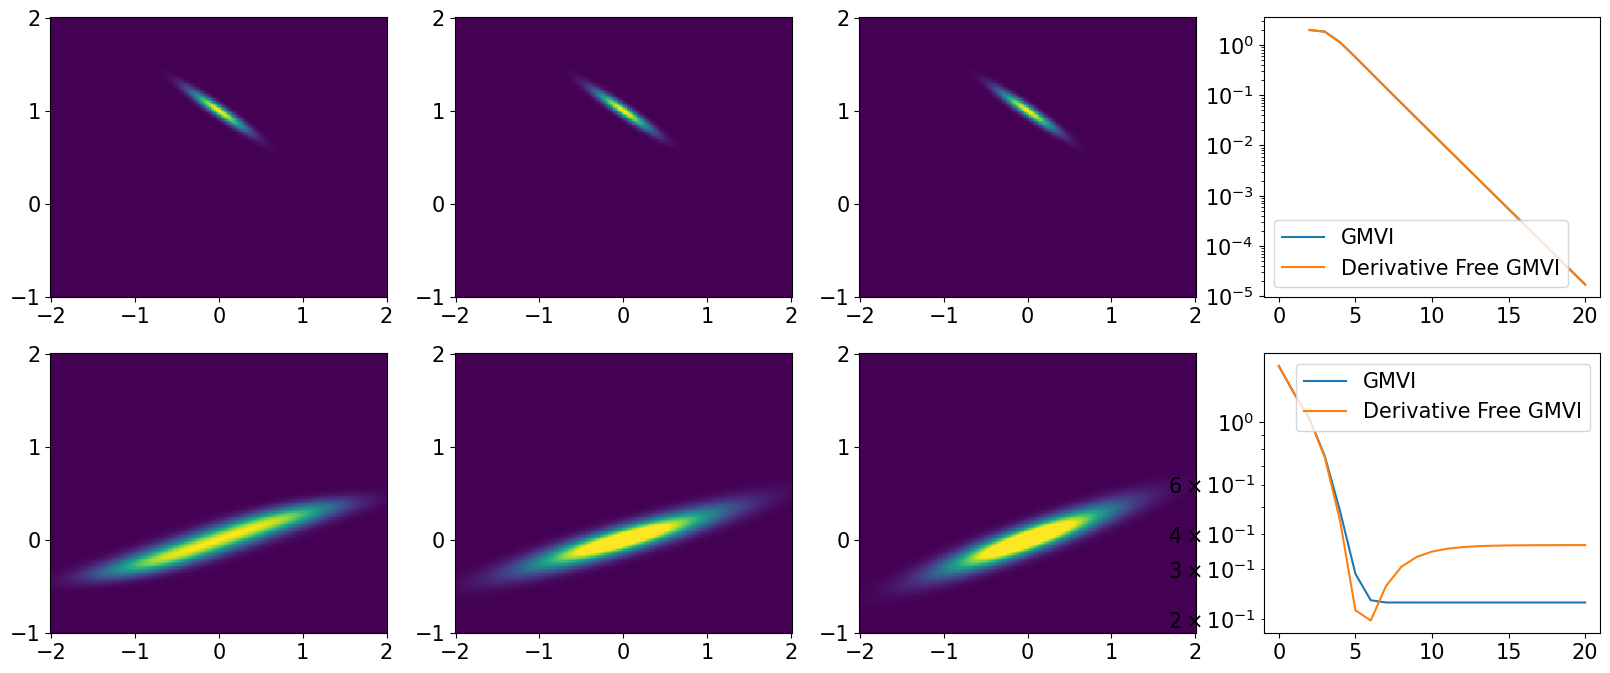

PyObject <matplotlib.legend.Legend object at 0x3439d0460>

In [25]:
fig, ax = PyPlot.subplots(nrows=2, ncols=4, sharex=false, sharey=false, figsize=(20,8))

    

y = [1.0; 2.0]
ση = 0.1
Gtype = "Gaussian"
A = [1.0 1.0; 1.0 2.0]
C_post, m_post = ση^2*inv(A'*A), (A'*A)\(A*y)
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_V(x) = V(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
gmgdobj, gmgdobj_BIP = Gaussian_VI(func_V, func_F, μ0, Σ0; N_iter = 20, dt = 5e-1)
args = (y, ση, A, Gtype, gmgdobj, gmgdobj_BIP);
Visualization(func_F, ax[1,:], 200, 200, [-2.0,2.0], [-1.0,2.0]; args=args)



y = [0.0; 0.0]
ση = 0.1
Gtype = "Logconcave"
λ = 0.1
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_V(x) = V(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
gmgdobj, gmgdobj_BIP = Gaussian_VI(func_V, func_F, μ0, Σ0; N_iter = 20, dt = 5e-1)
args = (y, ση, λ , Gtype, gmgdobj, gmgdobj_BIP);
Visualization(func_F, ax[2,:], 200, 200, [-2.0,2.0], [-1.0,2.0]; args=args)